# DETEKCIJA EMOCIJA
**Sofija Dangubić, IT15-2019**
_______
Podaci se sastoje od slika lica veličine 48x48 piksela u sivim tonovima. Lica su automatski registrovana tako da je lice manje-više centrirano i zauzima približno istu količinu prostora na svakoj slici. Zadatak je da svako lice kategoriše na osnovu emocija prikazanih u izrazu lica u jednu od sedam kategorija:


| kategorija | emocija |
|:---:|:---|
| 0 | Angry |
| 1 | Disgust |
| 2 | Fear |
| 3 | Happy |
| 4 | Now |
| 5 | Surprise |
| 6 | Neutral |

Definišemo jednostavan CNN model i upoređujemo predviđene rezultate sa datim oznakama.

1. Učitavamo potrebne standardne biblioteke i pakete kao što su sklearn i keras

In [50]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

from keras import models
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.utils import to_categorical

2. Definišemo putanju za unos i prikazujemo sve datoteke koje su u toj putanji (dataset je preuzet sa kaggle-a)

In [51]:
path = '/content/drive/MyDrive/ColabNotebooks/challenges-in-representation-learning-facial-expression-recognition-challenge/'
os.listdir(path)

['example_submission.csv',
 'fer2013.tar.gz',
 'icml_face_data.csv',
 'test.csv',
 'train.csv']

In [52]:
data = pd.read_csv(path+'icml_face_data.csv')
data.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


3. Definišemo nekoliko funkcija i jednu pomoćnu metodu za vizualizaciju podataka u sklopu analize podataka o emocijama

In [53]:
# Funkcija priprema podataka za modeliranje
#   ulaz: okvir podataka sa oznakama i podacima o pikselima
#   izlaz: slika i niz oznaka
def prepare_data(data):
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, ' pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image

    return image_array, image_label

# Funkcija prikazuje primere slika s određenom oznakom emocije
def plot_examples(label=0):
    fig, axs = plt.subplots(1, 5, figsize=(25, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(5):
        idx = data[data['emotion']==label].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])

# Funkcija prikazuje primere slika za sve dostupne emocije
# Prikazuje po jednu sliku za svaku emociju
def plot_all_emotions():
    fig, axs = plt.subplots(1, 7, figsize=(30, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(7):
        idx = data[data['emotion']==i].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])

# Funkcija prikazuje jednu sliku iz testnog skupa podataka, zajedno s njenom stvarnom emocijom i predikcijom emocije
def plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, image_number):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)

    bar_label = emotions.values()

    axs[0].imshow(test_image_array[image_number], 'gray')
    axs[0].set_title(emotions[test_image_label[image_number]])

    axs[1].bar(bar_label, pred_test_labels[image_number], color='orange', alpha=0.7)
    axs[1].grid()

    plt.show()

# Funkcija poredi distribucije emocija između dva skupa podataka
def plot_compare_distributions(array1, array2, title1='', title2=''):
    df_array1 = pd.DataFrame()
    df_array2 = pd.DataFrame()
    df_array1['emotion'] = array1.argmax(axis=1)
    df_array2['emotion'] = array2.argmax(axis=1)

    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    x = emotions.values()

    y = df_array1['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[0].bar(x, y.sort_index(), color='orange')
    axs[0].set_title(title1)
    axs[0].grid()

    y = df_array2['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[1].bar(x, y.sort_index())
    axs[1].set_title(title2)
    axs[1].grid()

    plt.show()

In [54]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

In [55]:
data[' Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name:  Usage, dtype: int64

4. Korišenjem funkcije prepare_data() pripremamo podatke za trening modela, validacionog modela i test modela

In [56]:
train_image_array, train_image_label = prepare_data(data[data[' Usage']=='Training'])
val_image_array, val_image_label = prepare_data(data[data[' Usage']=='PrivateTest'])
test_image_array, test_image_label = prepare_data(data[data[' Usage']=='PublicTest'])

In [57]:
train_images = train_image_array.reshape((train_image_array.shape[0], 48, 48, 1))
train_images = train_images.astype('float32')/255
val_images = val_image_array.reshape((val_image_array.shape[0], 48, 48, 1))
val_images = val_images.astype('float32')/255
test_images = test_image_array.reshape((test_image_array.shape[0], 48, 48, 1))
test_images = test_images.astype('float32')/255

5. Koristimo funkciju to_categorical() iz keras.utils modula kako bi se pretvorile oznake emocija iz numeričkog oblika u oblik kategoričkih varijabli

In [58]:
train_labels = to_categorical(train_image_label)
val_labels = to_categorical(val_image_label)
test_labels = to_categorical(test_image_label)

6. Prikazujemo sve emocije kao i 1 primer emocije korišćenjem plot-a

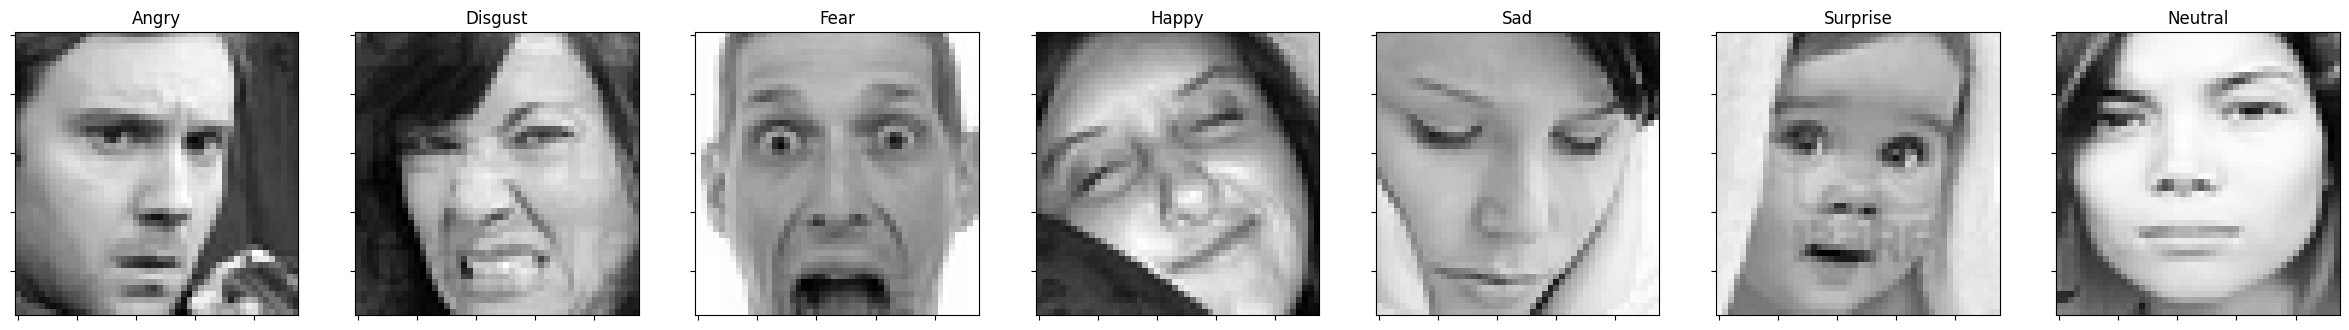

In [59]:
plot_all_emotions()

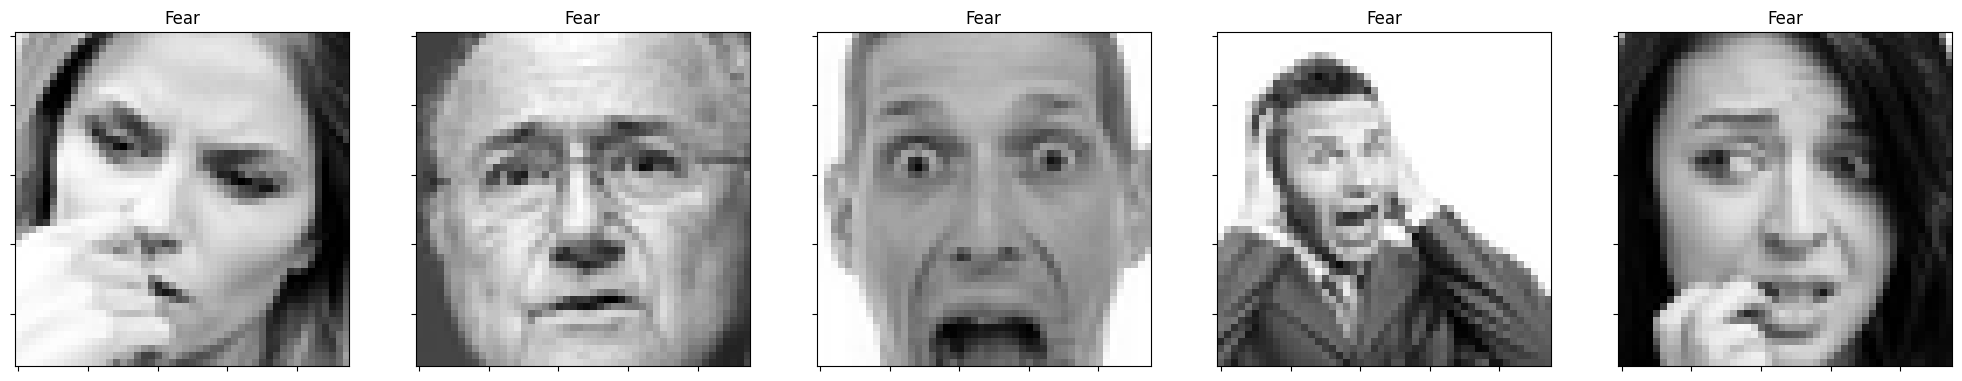

In [60]:
plot_examples(label=2)

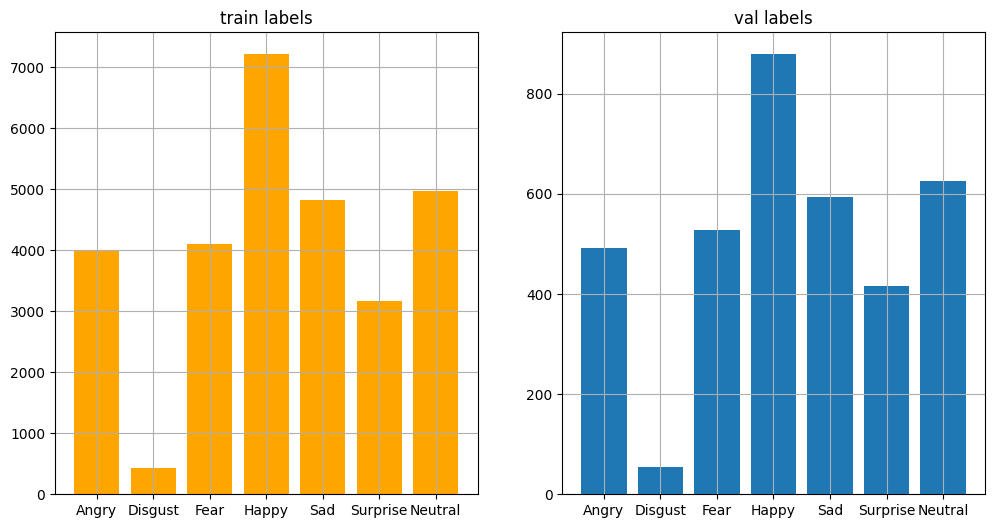

In [61]:
plot_compare_distributions(train_labels, val_labels, title1='train labels', title2='val labels')

7. Kreiramo klasu weight koja nam treba tokom treniranja modela kako bi rešili problem nebalansiranih klasa

In [62]:
class_weight = dict(zip(range(0, 7), (((data[data[' Usage']=='Training']['emotion'].value_counts()).sort_index())/len(data[data[' Usage']=='Training']['emotion'])).tolist()))
class_weight

{0: 0.1391549688251071,
 1: 0.01518687519593159,
 2: 0.14270786164617366,
 3: 0.2513149186666202,
 4: 0.16823992476226968,
 5: 0.11045316799609878,
 6: 0.17294228290779895}

8. Sledeće definišemo CNN korišćenjem Sequential modela iz biblioteke Keras

In [63]:
model = models.Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(7, activation='softmax'))

In [64]:
model.compile(optimizer=Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

In [65]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 23, 23, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 10, 10, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 64)          36928     
                                                                 
 flatten_1 (Flatten)         (None, 4096)             

9. Vršimo trening - kada se funkcija fit izvrši, model će se trenirati na trening skupu podataka koristeći navedene parametre i proveriti tačnost na validacijskom skupu podataka tokom svake epohe. Nakon završetka treniranja, biće uskladišteno u varijablu history, što omogućuje analizu performansi modela tokom treniranja

In [66]:
history = model.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    class_weight = class_weight,
                    epochs=12,
                    batch_size=64)

Epoch 1/12
449/449 [==============================] - 88s 195ms/step - loss: 0.2635 - accuracy: 0.3295 - val_loss: 1.5648 - val_accuracy: 0.4076
Epoch 2/12
449/449 [==============================] - 90s 201ms/step - loss: 0.2213 - accuracy: 0.4491 - val_loss: 1.4180 - val_accuracy: 0.4625
Epoch 3/12
449/449 [==============================] - 88s 195ms/step - loss: 0.2027 - accuracy: 0.4969 - val_loss: 1.3361 - val_accuracy: 0.4987
Epoch 4/12
449/449 [==============================] - 85s 189ms/step - loss: 0.1898 - accuracy: 0.5303 - val_loss: 1.2942 - val_accuracy: 0.5127
Epoch 5/12
449/449 [==============================] - 88s 196ms/step - loss: 0.1799 - accuracy: 0.5548 - val_loss: 1.2687 - val_accuracy: 0.5222
Epoch 6/12
449/449 [==============================] - 88s 196ms/step - loss: 0.1701 - accuracy: 0.5835 - val_loss: 1.2913 - val_accuracy: 0.5277
Epoch 7/12
449/449 [==============================] - 104s 233ms/step - loss: 0.1613 - accuracy: 0.6049 - val_loss: 1.2715 - val_a

10. Ovim korakom dobićemo konačnu procenu performansi modela na neviđenim podacima. To nam omogućuje da procenimo stvarnu efikasnost modela i da dobijemo uvid u njegovu sposobnost generalizacije na podatke koje nije vidio tokom treniranja ili validacije

In [67]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('test caccuracy:', test_acc)

113/113 [==============================] - 3s 24ms/step - loss: 1.3552 - accuracy: 0.5486
test caccuracy: 0.5486207604408264


In [68]:
pred_test_labels = model.predict(test_images)

113/113 [==============================] - 3s 24ms/step


11. Vizuelno pokazujemo promene gubitka tokom procesa učenja (treninaranja i validacije)

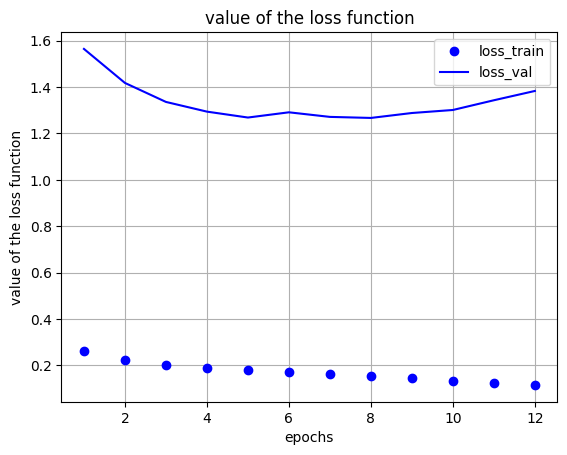

In [69]:
loss = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo', label='loss_train')
plt.plot(epochs, loss_val, 'b', label='loss_val')
plt.title('value of the loss function')
plt.xlabel('epochs')
plt.ylabel('value of the loss function')
plt.legend()
plt.grid()
plt.show()

12. Vizuelno pokazujemo promene tačnosti tokom procesa učenja (treninaranja i validacije)

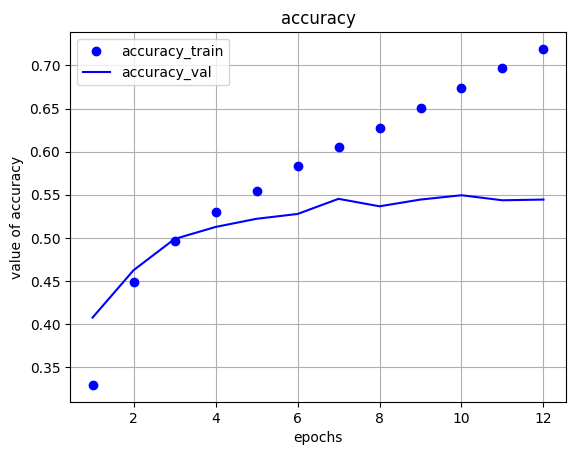

In [70]:
acc = history.history['accuracy']
acc_val = history.history['val_accuracy']
epochs = range(1, len(loss)+1)
plt.plot(epochs, acc, 'bo', label='accuracy_train')
plt.plot(epochs, acc_val, 'b', label='accuracy_val')
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('value of accuracy')
plt.legend()
plt.grid()
plt.show()

12. Proveramo ono što smo do sad definisali i istrenirali odabirom 2 slike iz dataset-a i plot-ovanjem odgovora

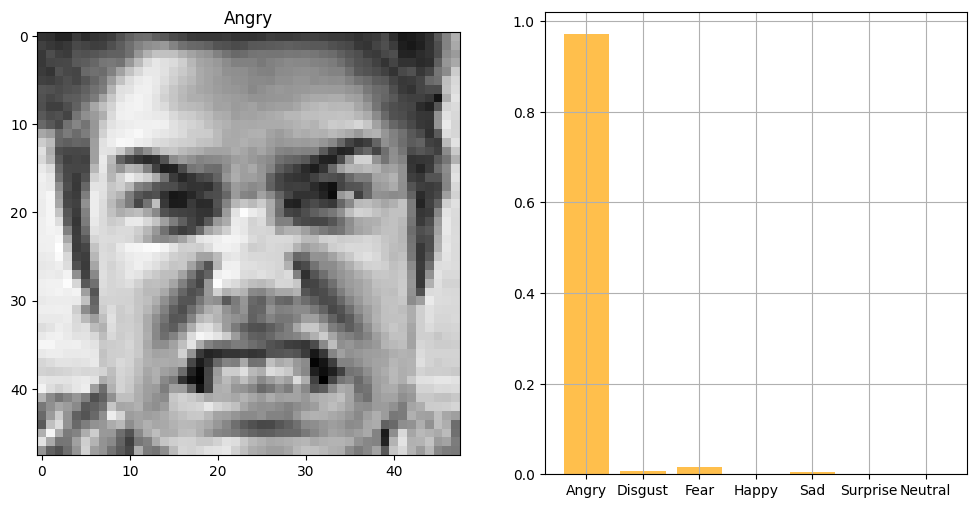

In [71]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 40)

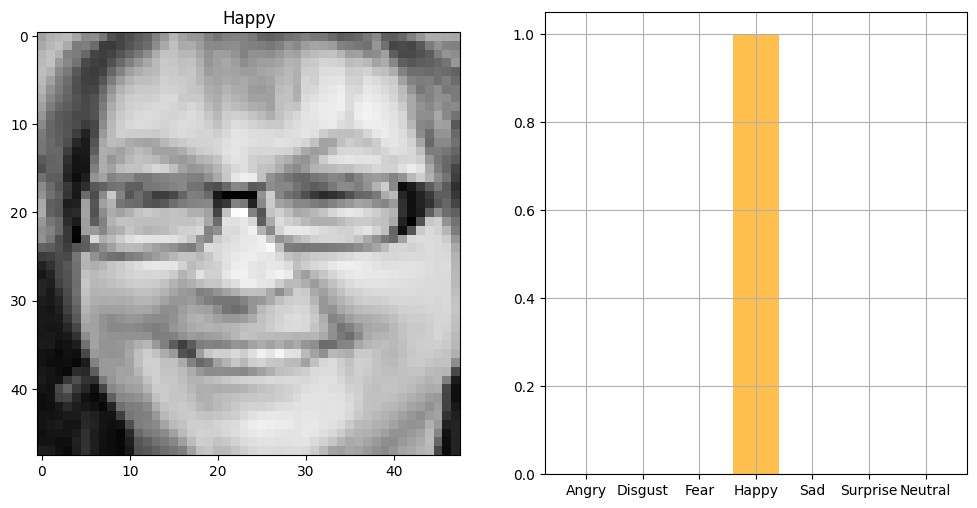

In [72]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 100)

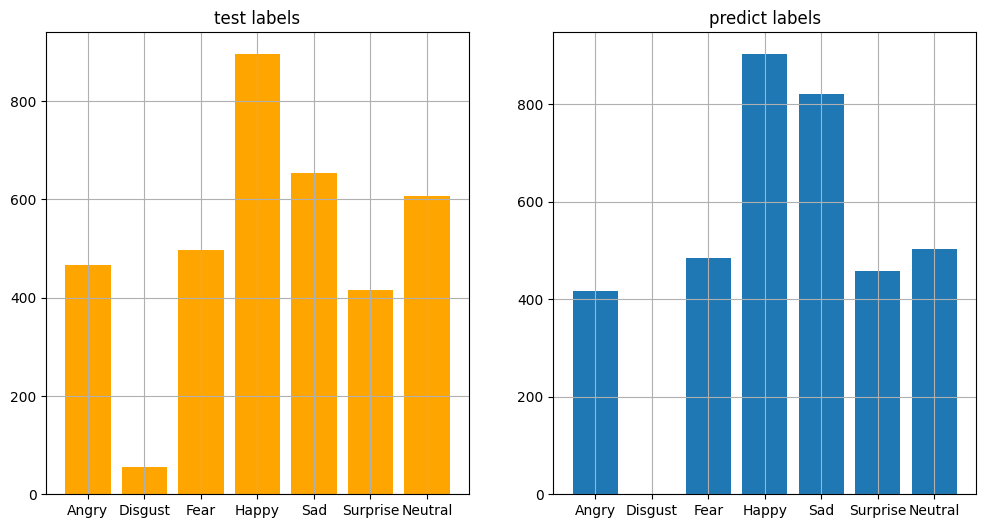

In [73]:
plot_compare_distributions(test_labels, pred_test_labels, title1='test labels', title2='predict labels')

13. Generišemo matricu komfuzije da proverimo tačnost i netačnost stvarnih od predikcionih emocija (najtamnije polje označava da najveći broj slika koje su stvarno pripadale toj klasi su pogrešno klasifikovane kao neka druga klasa emocije)

In [74]:
df_compare = pd.DataFrame()
df_compare['real'] = test_labels.argmax(axis=1)
df_compare['pred'] = pred_test_labels.argmax(axis=1)
df_compare['wrong'] = np.where(df_compare['real']!=df_compare['pred'], 1, 0)

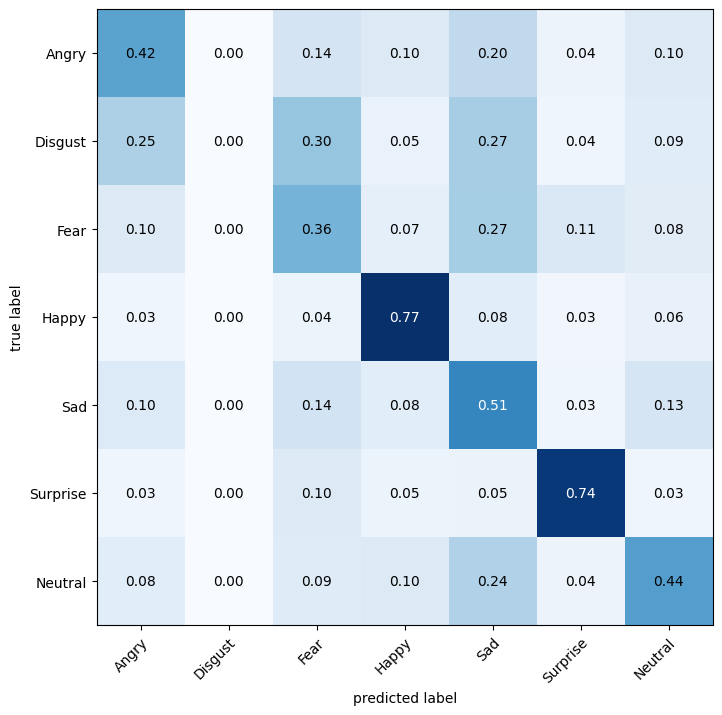

In [75]:
conf_mat = confusion_matrix(test_labels.argmax(axis=1), pred_test_labels.argmax(axis=1))

fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                show_normed=True,
                                show_absolute=False,
                                class_names=emotions.values(),
                                figsize=(8, 8))
fig.show()

# MATERIJALI

[Dataset preuzet sa Kaggle-a](https://www.kaggle.com/competitions/challenges-in-representation-learning-facial-expression-recognition-challenge/code)

[Pomoćni kodovi za izradu projekta](https://colab.research.google.com/drive/1XiJ-sa5Kg324mpq_XG_JMWOlfj_DvZFv#scrollTo=Iq3q_MMdZupg)

